In [74]:
# %pip install pandas matplotlib numpy seaborn scikit-learn

In [99]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
df =pd.read_csv('insurance.csv')

In [77]:
df.head()

,age,weight,height,income_lpa,smoker,city,occupation,insurance_premium_category
0,67,119.8,1.56,2.92,False,Jaipur,retired,High
1,36,101.1,1.83,34.28,False,Chennai,freelancer,Low
2,39,56.8,1.64,36.64,False,Indore,freelancer,Low
3,22,109.4,1.55,3.34,True,Mumbai,student,Medium
4,69,62.2,1.60,3.94,True,Indore,retired,High


In [78]:
df['occupation'].unique()

array(['retired', 'freelancer', 'student', 'government_job',
       'business_owner', 'unemployed', 'private_job'], dtype=object)

In [79]:
df_feat =df.copy()

In [80]:
#feature engineering 
#bmi as feature 1
df_feat['bmi'] = df_feat['weight'] / (df_feat['height']**2)

In [81]:
# age group as feature 2
def age_group(age):
    if age < 25:
        return 'young'
    elif age < 45:
        return 'adult'
    elif age < 65:
        return 'middle_aged'
    else:
        return 'senior'

In [82]:
df_feat['age_group'] = df_feat['age'].apply(age_group)

In [83]:
#feature 3  as lifestyle risk
def lifestyle_risk(row):
    if row['smoker'] and row['bmi'] >30:
        return "high"
    elif row['smoker'] or row['bmi'] > 27:
        return "medium"
    else:
        return "low"

In [84]:
df_feat["lifestyle_risk"] = df_feat.apply(lifestyle_risk, axis=1)

ValueError: 'facecolor' or 'color' argument must be a valid color orsequence of colors.

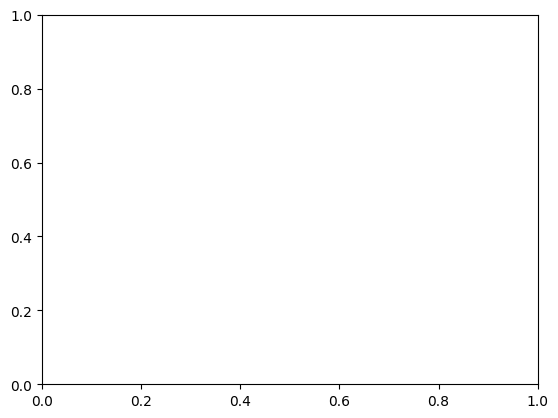

In [102]:
#visualizing the lifestyle risk as a pie
plt.bar(x=df_feat['lifestyle_risk'].value_counts().index
              , height=df_feat['lifestyle_risk'].value_counts().values,color =df_feat['lifestyle_risk'].value_counts().index)
plt.title('Lifestyle Risk Distribution')
plt.xlabel('Lifestyle Risk')
plt.ylabel('Count')
plt.show()

In [85]:
tier_1_cities = ["Mumbai", "Delhi", "Bangalore", "Chennai", "Kolkata", "Hyderabad", "Pune"]
tier_2_cities = [
    "Jaipur", "Chandigarh", "Indore", "Lucknow", "Patna", "Ranchi", "Visakhapatnam", "Coimbatore",
    "Bhopal", "Nagpur", "Vadodara", "Surat", "Rajkot", "Jodhpur", "Raipur", "Amritsar", "Varanasi",
    "Agra", "Dehradun", "Mysore", "Jabalpur", "Guwahati", "Thiruvananthapuram", "Ludhiana", "Nashik",
    "Allahabad", "Udaipur", "Aurangabad", "Hubli", "Belgaum", "Salem", "Vijayawada", "Tiruchirappalli",
    "Bhavnagar", "Gwalior", "Dhanbad", "Bareilly", "Aligarh", "Gaya", "Kozhikode", "Warangal",
    "Kolhapur", "Bilaspur", "Jalandhar", "Noida", "Guntur", "Asansol", "Siliguri"
]

In [86]:
# Feature 4: City Tier
def city_tier(city):
    if city in tier_1_cities:
        return 1
    elif city in tier_2_cities:
        return 2
    else:
        return 3

In [87]:
df_feat["city_tier"] = df_feat["city"].apply(city_tier)

In [88]:
df_feat.drop(columns=['age', 'weight', 'height', 'smoker', 'city'])[['income_lpa', 'occupation', 'bmi', 'age_group', 'lifestyle_risk', 'city_tier', 'insurance_premium_category']].sample(5)

,income_lpa,occupation,bmi,age_group,lifestyle_risk,city_tier,insurance_premium_category
37,8.090000,freelancer,17.852127,adult,low,2,Medium
7,10.865821,government_job,33.360687,adult,high,1,Medium
48,32.690000,unemployed,34.402671,adult,high,1,Medium
84,0.620000,retired,28.801497,senior,medium,2,High
94,10.542289,government_job,33.266002,middle_aged,medium,1,Low


In [89]:
# Select features and target
X = df_feat[["bmi", "age_group", "lifestyle_risk", "city_tier", "income_lpa", "occupation"]]
y = df_feat["insurance_premium_category"]

In [90]:
X

,bmi,age_group,lifestyle_risk,city_tier,income_lpa,occupation
0,49.227482,senior,medium,2,2.92000,retired
1,30.189017,adult,medium,1,34.28000,freelancer
2,21.118382,adult,low,2,36.64000,freelancer
3,45.535900,young,high,1,3.34000,student
4,24.296875,senior,medium,2,3.94000,retired
...,...,...,...,...,...,...
95,21.420747,adult,low,2,19.64000,business_owner
96,47.984483,adult,medium,1,34.01000,private_job
97,18.765432,middle_aged,low,1,44.86000,freelancer
98,30.521676,adult,medium,1,28.30000,business_owner


In [91]:
y

0       High
1        Low
2        Low
3     Medium
4       High
       ...  
95       Low
96       Low
97       Low
98       Low
99       Low
Name: insurance_premium_category, Length: 100, dtype: object

In [92]:
# Define categorical and numeric features
categorical_features = ["age_group", "lifestyle_risk", "occupation", "city_tier"]
numeric_features = ["bmi", "income_lpa"]

In [93]:
#create column transformer for OHE
preprocessor = ColumnTransformer(
    transformers= [
        ("cat",OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

In [94]:
# creating Pipeline
pipeline =Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [95]:
# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['age_group',
                                                   'lifestyle_risk',
                                                   'occupation', 'city_tier']),
                                                 ('num', 'passthrough',
                                                  ['bmi', 'income_lpa'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [96]:
# Predict and evaluate
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.85

In [97]:
X_test.sample(5)

,bmi,age_group,lifestyle_risk,city_tier,income_lpa,occupation
32,31.495845,middle_aged,medium,2,50.00,private_job
51,38.827923,middle_aged,high,2,28.95,private_job
93,23.199416,young,low,2,1.28,student
80,34.350461,middle_aged,medium,2,50.00,unemployed
31,15.258742,adult,medium,2,11.77,private_job


In [98]:
import pickle
#save the model
pickle_model_path ="model.pkl"
with open(pickle_model_path,"wb") as f:
    pickle.dump(pipeline, f)